In [3]:
# Step 1: Importing Essential Libraries and Loading Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

In [4]:
# Load movie and rating data (ensure CSV files are in your working directory)
movie_data = pd.read_csv("movies.csv")
rating_data = pd.read_csv("ratings.csv")

In [5]:
# Display basic information about the movies dataset
print("Movies Data Info:")
print(movie_data.info())
print(movie_data.describe())
print(movie_data.head())

print("\nRatings Data Info:")
print(rating_data.info())
print(rating_data.head())

Movies Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB
None
             movieId
count   10329.000000
mean    31924.282893
std     37734.741149
min         1.000000
25%      3240.000000
50%      7088.000000
75%     59900.000000
max    149532.000000
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fanta

In [6]:
# Step 2: Data Pre-processing – One-Hot Encoding of Genres
# Split the 'genres' column (which contains strings with genres separated by '|')
movie_data['genres_list'] = movie_data['genres'].apply(lambda x: x.split('|'))

# Define the list of genres (same as used in the R code)
all_genres = ["Action", "Adventure", "Animation", "Children", "Comedy", "Crime",
              "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
              "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

# Create one-hot encoding for each genre
for genre in all_genres:
    movie_data[genre] = movie_data['genres_list'].apply(lambda genres: 1 if genre in genres else 0)

# Create a search matrix that includes movieId, title, and genre columns
search_matrix = movie_data[['movieId', 'title'] + all_genres]
print("\nSearch Matrix (first 5 rows):")
print(search_matrix.head())

# Step 3: Construct the Rating Matrix
# Create a pivot table where rows are users and columns are movies
rating_matrix = rating_data.pivot(index='userId', columns='movieId', values='rating')
print("\nRating Matrix shape:", rating_matrix.shape)

# (Optional) Convert to a sparse matrix if needed for efficiency:
rating_matrix_sparse = csr_matrix(rating_matrix.fillna(0).values)

# Step 4: Exploring Similarity – Users and Movies
# For users: compute cosine similarity on the first 4 users (fill NaNs with 0)
user_similarity = cosine_similarity(rating_matrix.iloc[:4].fillna(0))
print("\nUser Similarity (first 4 users):")
print(user_similarity)


Search Matrix (first 5 rows):
   movieId                               title  Action  Adventure  Animation  \
0        1                    Toy Story (1995)       0          1          1   
1        2                      Jumanji (1995)       0          1          0   
2        3             Grumpier Old Men (1995)       0          0          0   
3        4            Waiting to Exhale (1995)       0          0          0   
4        5  Father of the Bride Part II (1995)       0          0          0   

   Children  Comedy  Crime  Documentary  Drama  Fantasy  Film-Noir  Horror  \
0         1       1      0            0      0        1          0       0   
1         1       0      0            0      0        1          0       0   
2         0       1      0            0      0        0          0       0   
3         0       1      0            0      1        0          0       0   
4         0       1      0            0      0        0          0       0   

   Musical  Mystery

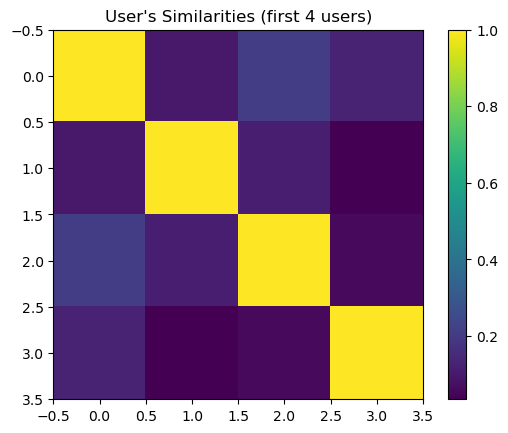

In [7]:
plt.figure()
plt.imshow(user_similarity, interpolation='nearest', cmap='viridis')
plt.title("User's Similarities (first 4 users)")
plt.colorbar()
plt.show()

In [8]:
# For movies: compute cosine similarity on the first 4 movies
# (Transposing so that movies are treated as vectors)
movie_similarity = cosine_similarity(rating_matrix.iloc[:, :4].fillna(0).T)
print("\nMovie Similarity (first 4 movies):")
print(movie_similarity)


Movie Similarity (first 4 movies):
[[1.         0.38306843 0.33745279 0.13472433]
 [0.38306843 1.         0.19920682 0.12337653]
 [0.33745279 0.19920682 1.         0.17336631]
 [0.13472433 0.12337653 0.17336631 1.        ]]


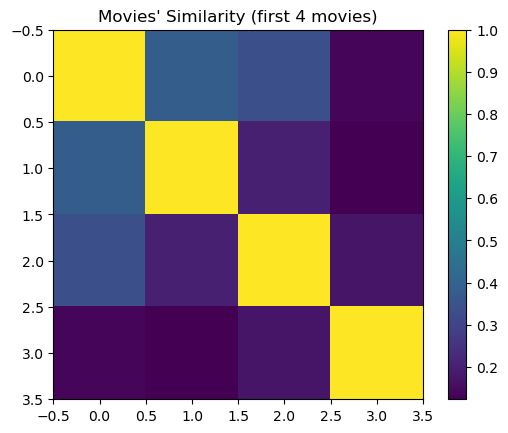

In [9]:
plt.figure()
plt.imshow(movie_similarity, interpolation='nearest', cmap='viridis')
plt.title("Movies' Similarity (first 4 movies)")
plt.colorbar()
plt.show()

In [11]:
# Step 5: Unique Ratings and Table of Ratings
# Get unique rating values (ignoring NaNs)
unique_ratings = np.unique(rating_matrix.values[~np.isnan(rating_matrix.values)])
print("\nUnique Ratings:", unique_ratings)

# Count the occurrence of each rating from the raw rating data
table_of_ratings = rating_data['rating'].value_counts().sort_index()
print("\nTable of Ratings:")
print(table_of_ratings)


Unique Ratings: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]

Table of Ratings:
rating
0.5     1198
1.0     3258
1.5     1567
2.0     7943
2.5     5484
3.0    21729
3.5    12237
4.0    28880
4.5     8187
5.0    14856
Name: count, dtype: int64



Top 6 Most Viewed Movies:
   movieId  views                                      title
0      296    325                        Pulp Fiction (1994)
1      356    311                        Forrest Gump (1994)
2      318    308           Shawshank Redemption, The (1994)
3      480    294                       Jurassic Park (1993)
4      593    290           Silence of the Lambs, The (1991)
5      260    273  Star Wars: Episode IV - A New Hope (1977)


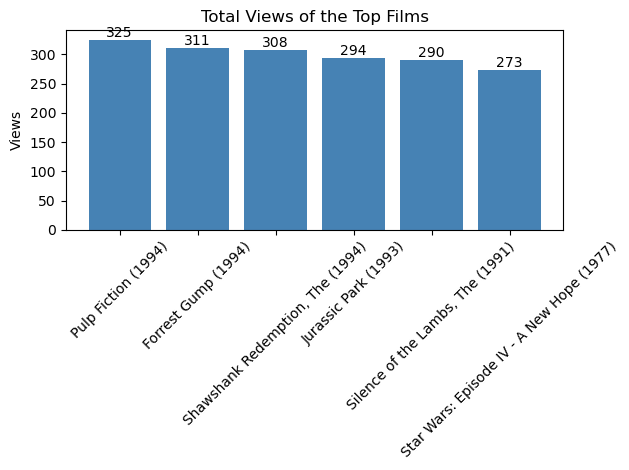

In [12]:
# Step 6: Most Viewed Movies Visualization
# Count how many ratings each movie received (i.e. number of views)
movie_views = rating_matrix.count(axis=0)
table_views = pd.DataFrame({'movieId': movie_views.index, 'views': movie_views.values})
table_views = table_views.sort_values(by='views', ascending=False)

# Merge with movie_data to get movie titles
table_views = table_views.merge(movie_data[['movieId', 'title']], on='movieId', how='left')
print("\nTop 6 Most Viewed Movies:")
print(table_views.head(6))

# Plot the top 6 most viewed movies
top6 = table_views.head(6)
plt.figure()
plt.bar(top6['title'], top6['views'], color='steelblue')
plt.xticks(rotation=45)
for i, v in enumerate(top6['views']):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title("Total Views of the Top Films")
plt.ylabel("Views")
plt.tight_layout()
plt.show()

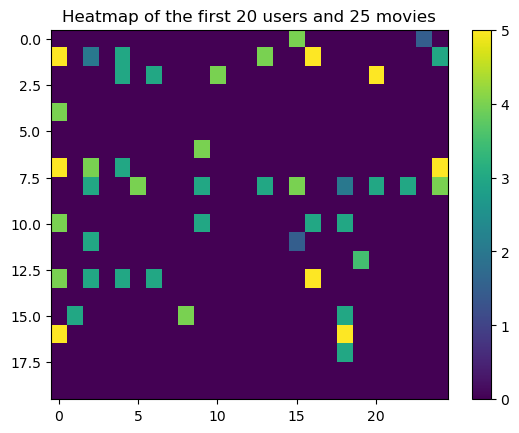

In [13]:
# Step 7: Heatmap of a Portion of the Rating Matrix
# Display a heatmap of the first 20 users and 25 movies
plt.figure()
plt.imshow(rating_matrix.iloc[0:20, 0:25].fillna(0), aspect='auto', cmap='viridis')
plt.title("Heatmap of the first 20 users and 25 movies")
plt.colorbar()
plt.show()


Filtered Rating Matrix shape: (420, 447)


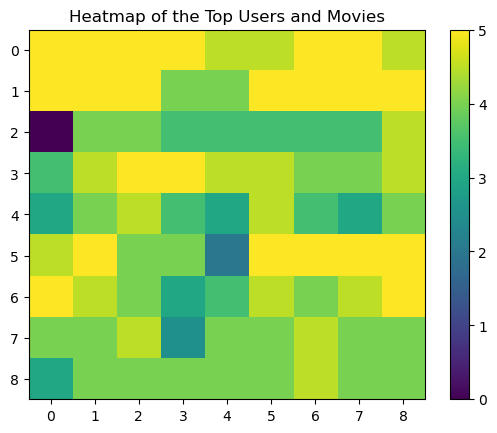

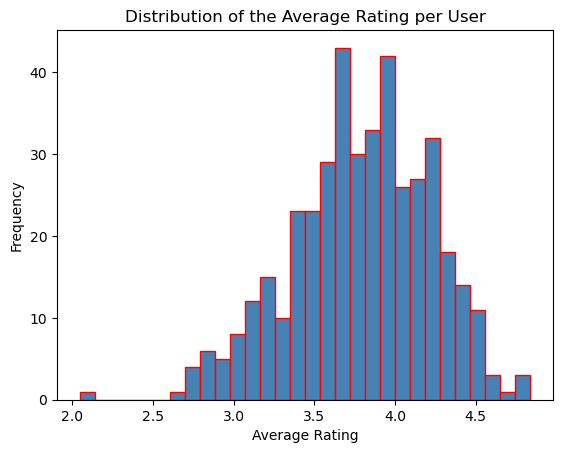


Number of users with non-zero mean (should be near zero): 0


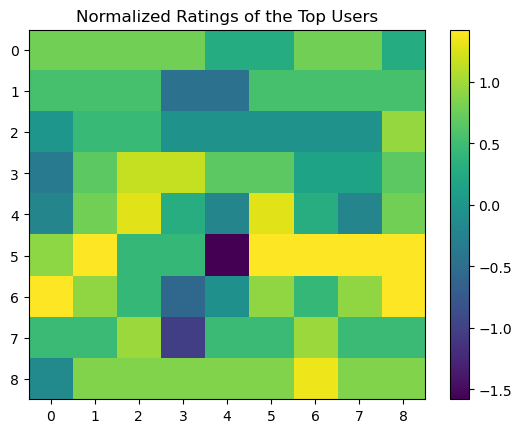

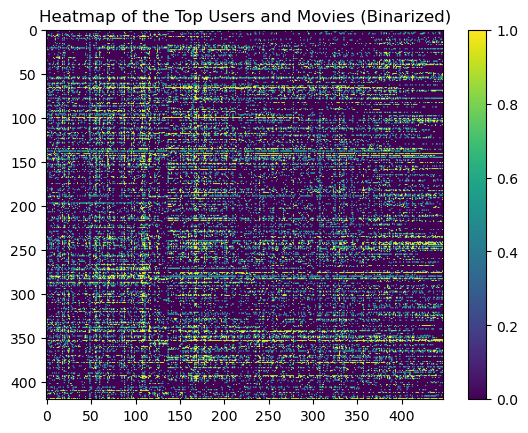

In [15]:
# Step 8: Data Preparation – Filtering, Normalization, and Binarization
# Filter out users and movies with fewer than 50 ratings
filtered_users = rating_matrix.count(axis=1) > 50
filtered_movies = rating_matrix.count(axis=0) > 50
movie_ratings = rating_matrix.loc[filtered_users, filtered_movies]
print("\nFiltered Rating Matrix shape:", movie_ratings.shape)

# (a) For further filtering: select top users/movies by count (98th percentile)
min_movies = movie_ratings.count(axis=1).quantile(0.98)
min_users = movie_ratings.count(axis=0).quantile(0.98)
top_users = movie_ratings[movie_ratings.count(axis=1) > min_movies]
top_movies = movie_ratings.loc[:, movie_ratings.count(axis=0) > min_users]

plt.figure()
plt.imshow(top_users[top_movies.columns].fillna(0), aspect='auto', cmap='viridis')
plt.title("Heatmap of the Top Users and Movies")
plt.colorbar()
plt.show()

# (b) Distribution of average ratings per user
average_ratings = movie_ratings.mean(axis=1)
plt.figure()
plt.hist(average_ratings, bins=30, color='steelblue', edgecolor='red')
plt.title("Distribution of the Average Rating per User")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

# (c) Data Normalization – subtract the mean rating of each user
normalized_ratings = movie_ratings.sub(movie_ratings.mean(axis=1), axis=0)
print("\nNumber of users with non-zero mean (should be near zero):",
      (normalized_ratings.mean(axis=1).abs() > 1e-5).sum())

plt.figure()
plt.imshow(normalized_ratings.loc[normalized_ratings.count(axis=1) > min_movies,
                                  normalized_ratings.count(axis=0) > min_users].fillna(0),
           aspect='auto', cmap='viridis')
plt.title("Normalized Ratings of the Top Users")
plt.colorbar()
plt.show()

# (d) Data Binarization – convert ratings to 1 if rating >= 3, else 0
binary_min_movies = movie_ratings.count(axis=1).quantile(0.95)
binary_min_users = movie_ratings.count(axis=0).quantile(0.95)
good_rated_films = (movie_ratings >= 3).astype(int)

top_binary_users = good_rated_films[good_rated_films.count(axis=1) > binary_min_movies]
top_binary_movies = good_rated_films.loc[:, good_rated_films.count(axis=0) > binary_min_users]

plt.figure()
plt.imshow(top_binary_users[top_binary_movies.columns], aspect='auto', cmap='viridis')
plt.title("Heatmap of the Top Users and Movies (Binarized)")
plt.colorbar()
plt.show()

In [16]:
# Step 9: Collaborative Filtering – Splitting Data into Training and Testing Sets
# Randomly split the filtered movie ratings into 80% training and 20% testing
msk = np.random.rand(len(movie_ratings)) < 0.8
training_data = movie_ratings[msk]
testing_data = movie_ratings[~msk]
print("\nTraining data shape:", training_data.shape)
print("Testing data shape:", testing_data.shape)


Training data shape: (331, 447)
Testing data shape: (89, 447)



Item similarity matrix shape: (447, 447)


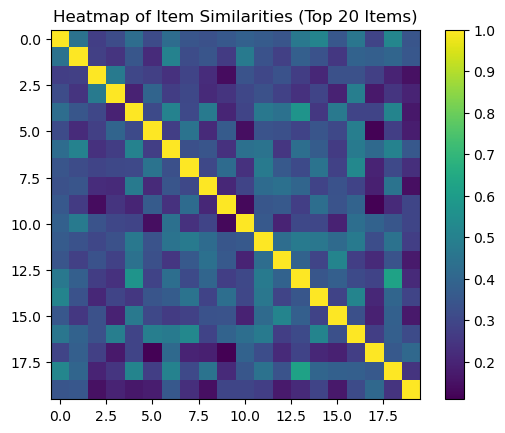

In [17]:
# Step 10: Building an Item-Based Collaborative Filtering Model
# Compute item-item similarity matrix using the training data (fill missing values with 0)
item_similarity = cosine_similarity(training_data.fillna(0).T)
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=training_data.columns,
                                  columns=training_data.columns)
print("\nItem similarity matrix shape:", item_similarity_df.shape)

# (Optional) Visualize a heatmap of the top 20 items’ similarities
top_items = 20
plt.figure()
plt.imshow(item_similarity_df.iloc[:top_items, :top_items], interpolation='nearest', cmap='viridis')
plt.title("Heatmap of Item Similarities (Top 20 Items)")
plt.colorbar()
plt.show()

# Define a simple prediction function for a given user using weighted average
def predict_ratings(user_ratings, similarity_df):
    preds = {}
    # For each movie that the user has not rated
    for movie in user_ratings.index:
        if pd.isna(user_ratings[movie]):
            # Consider movies that the user has rated
            rated = user_ratings.notna()
            if rated.sum() == 0:
                preds[movie] = np.nan
            else:
                sims = similarity_df.loc[movie, rated]
                ratings = user_ratings[rated]
                if sims.sum() > 0:
                    preds[movie] = np.dot(sims, ratings) / sims.sum()
                else:
                    preds[movie] = np.nan
    return preds

In [21]:
# Step 11: Generate Recommendations for Users in the Test Set
top_n = 10  # number of items to recommend per user
recommendations = {}

# Loop through each user in the test set to generate recommendations
for user_id, user_ratings in testing_data.iterrows():
    preds = predict_ratings(user_ratings, item_similarity_df)
    # Sort the predictions in descending order (ignoring movies with NaN predictions)
    sorted_preds = sorted(preds.items(), key=lambda x: x[1] if not pd.isna(x[1]) else -np.inf, reverse=True)
    recommendations[user_id] = sorted_preds[:top_n]

# Example: Show recommendations for one test user
example_user = list(recommendations.keys())[1]
recommended_movie_ids = [movie for movie, score in recommendations[example_user]]
# Retrieve movie titles from movie_data

recommended_titles = movie_data[movie_data['movieId'].isin(recommended_movie_ids)]['title'].tolist()
print("\nRecommendations for user", example_user, ":")
for i, title in enumerate(recommended_titles, start=1):
    print(f"{i}. {title}")



Recommendations for user 16 :
1. Heat (1995)
2. Craft, The (1996)
3. Long Kiss Goodnight, The (1996)
4. Boot, Das (Boat, The) (1981)
5. Star Trek: First Contact (1996)
6. Star Trek IV: The Voyage Home (1986)
7. Sneakers (1992)
8. Last of the Mohicans, The (1992)
9. Saint, The (1997)
10. Payback (1999)
